<h2>Подготовка данных</h2>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

In [21]:
df = pd.read_csv('data_lab3v01.csv', names = ['x1', 'x2', 'y'])

In [22]:
df.head()

,x1,x2,y
0,1.6715,0.95858,1
1,1.1920,0.39126,1
2,1.6228,1.88600,1
3,3.4380,2.85800,1
4,2.7135,3.65780,1


In [23]:
print(f"sample size: {df.shape[0]}")
print(f"sample size for each class: \n{df['y'].value_counts()}")

sample size: 500
sample size for each class: 
2    150
3    150
1    100
4    100
Name: y, dtype: int64


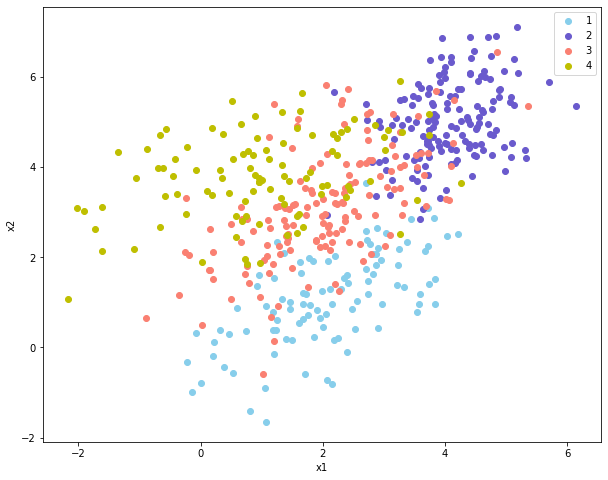

In [24]:
plt.figure(figsize=(10, 8))
for i, color in enumerate(['skyblue', 'slateblue', 'salmon', 'y']):
    plt.scatter(df[df.loc[:, 'y'] == i + 1].loc[:, 'x1'], df[df.loc[:, 'y'] == i + 1].loc[:, 'x2'], c = color, label = i + 1)

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

In [25]:
df_buf = df.sample(frac = 0.9, random_state = 200)
df_test = df.drop(df_buf.index)

df_train = df_buf.sample(frac = 0.667, random_state = 200)
df_valid = df_buf.drop(df_train.index)

print(f"sample size for train: \n{df_train['y'].value_counts()}\n")
print(f"sample size for valid: \n{df_valid['y'].value_counts()}\n")
print(f"sample size for test: \n{df_test['y'].value_counts()}")

sample size for train: 
2    89
3    88
4    66
1    57
Name: y, dtype: int64

sample size for valid: 
2    46
3    46
1    34
4    24
Name: y, dtype: int64

sample size for test: 
3    16
2    15
4    10
1     9
Name: y, dtype: int64


array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>]], dtype=object)

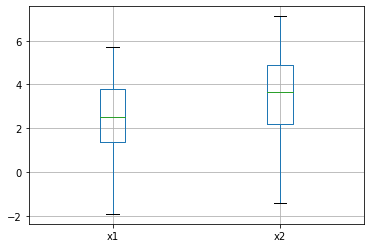

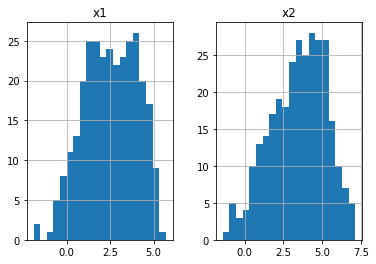

In [26]:
df_train.boxplot(column = ['x1', 'x2'])
df_train.hist(column = ['x1', 'x2'], bins = 20)

In [27]:
def prepare_data(df):
    df.reset_index(drop= True , inplace= True )
    labels = df.loc[:, 'y']
    df = df.drop(columns = ['y'])
    columns = [x for x in df]

    df_for_train = df_train.drop(columns = ['y'])
    transformer = RobustScaler().fit(df_for_train)
    data_new = transformer.transform(df)
    
    return data_new, pd.get_dummies(labels, columns=['y']).to_numpy(dtype = np.float64)

y after encoding:
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
{'whiskers': [<matplotlib.lines.Line2D object at 0x0000014876D08820>, <matplotlib.lines.Line2D object at 0x0000014876D08B80>, <matplotlib.lines.Line2D object at 0x0000014876D21040>, <matplotlib.lines.Line2D object at 0x0000014876D213A0>], 'caps': [<matplotlib.lines.Line2D object at 0x0000014876D08EE0>, <matplotlib.lines.Line2D object at 0x0000014876D13280>, <matplotlib.lines.Line2D object at 0x0000014876D21700>, <matplotlib.lines.Line2D object at 0x0000014876D21A60>], 'boxes': [<matplotlib.lines.Line2D object at 0x0000014876D08490>, <matplotlib.lines.Line2D object at 0x0000014876D13CA0>], 'medians': [<matplotlib.lines.Line2D object at 0x0000014876D135E0>, <matplotlib.lines.Line2D object at 0x0000014876D21DC0>], 'fliers': [<matplotlib.lines.Line2D object at 0x0000014876D13940>, <matplotlib.lines.Line2D object at 0x0000014876D2E160>], 'means': []}


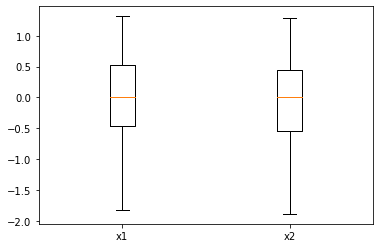

In [28]:
x_train, y_train = prepare_data(df_train)
print(f"y after encoding:\n {y_train[:5]}")
print(plt.boxplot(x_train, labels = ['x1', 'x2']))

<h2>Архитекутра и обучение НС</h2>

In [29]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [30]:
class ClassNet(nn.Module):
    
    def __init__(self):
        super(ClassNet, self).__init__()

        self.fc1 = nn.Linear(2, 5, dtype = torch.float64)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.act2 = nn.functional.tanh

        self.fc2 = nn.Linear(5, 5, dtype = torch.float64)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.act3 = nn.functional.tanh

        self.fc3 = nn.Linear(5, 4, dtype = torch.float64)
        nn.init.xavier_uniform_(self.fc3.weight)

        self.act4 = nn.Softmax(dim = 0)

    def forward(self, x, hard = False):
        x = self.fc1(x)
        x = self.act2(x)

        x = self.fc2(x)
        x = self.act3(x)

        x = self.fc3(x)
        x = self.act4(x)
        
        if hard:
            x = torch.argmax(x, dim = 1)
            
        return x

In [31]:
def get_classification_loss(net, x, y):
    y_pred = net.forward(x, hard = True)
    y = np.argmax(y, axis = 1)
    return 1 - accuracy_score(y, y_pred)

In [32]:
def fit_net(net, x_train, y_train, x_valid, y_valid, x_test, y_test, epoch = 100, lr = 0.01, momentum = 0.5):
    X_buf = x_train.copy()
    y_buf = y_train.copy()

    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train)
    x_valid = torch.from_numpy(x_valid)
    y_valid = torch.from_numpy(y_valid)
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)

    step_losses = []
    train_losses = []
    valid_losses = []
    test_losses = []

    train_class_losses = []
    valid_class_losses = []
    test_class_losses = []

    CE_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum = momentum)

    n = x_train.size(dim = 0)
    for _ in range(epoch):

        X_y = np.array(list(zip(X_buf, y_buf)), dtype = object)
        np.random.shuffle(X_y)
        X, y = list(zip(*X_y))
        X = torch.tensor(X, requires_grad=True)
        y = torch.tensor(y, dtype = torch.float64)

        for i in range(n):
            optimizer.zero_grad() 
            y_pred = net.forward(X[i])
            L = CE_loss(y[i], y_pred)
            L.backward()
            optimizer.step()

        y_pred = net.forward(x_train)
        L_train = CE_loss(y_pred, y_train)
        train_losses.append(L_train.item())

        y_pred_test = net.forward(x_test)
        L_test = CE_loss(y_pred_test, y_test)
        test_losses.append(L_test.item())

        y_pred_valid = net.forward(x_valid)
        L_valid = CE_loss(y_pred_valid, y_valid)
        valid_losses.append(L_valid.item())

        train_class_losses.append(get_classification_loss(net, x_train, y_train))
        valid_class_losses.append(get_classification_loss(net, x_valid, y_valid))
        test_class_losses.append(get_classification_loss(net, x_test, y_test))

        if ((len(step_losses) > 0) and (step_losses[-1] < L_valid.item())):
            step_losses.append(L_valid.item())
        else:
            step_losses = [L_valid.item()]

        if len(step_losses) >= 10:
            break

    return train_losses, valid_losses, test_losses, train_class_losses, valid_class_losses, test_class_losses

<h2>Визуализация результатов обучения НС</h2>

In [33]:
def visualize_losses(losses, title):
    
    t = np.arange(1, len(losses[0]) + 1)
    plt.figure(figsize=(12, 8))
    plt.plot(t, losses[0], label = "loss training")
    plt.plot(t, losses[1], label = "loss valid")
    plt.plot(t, losses[2], label = "loss test")

    plt.legend(fontsize = 20, loc = 'upper right')
    plt.xlabel("t")
    plt.ylabel("$E(t)$")
    plt.title(title)
    plt.show()

In [34]:
def get_df_losses(losses):
    data = {'train': [round(losses[0][-1], 3), round(losses[3][-1], 3)],
        'valid': [round(losses[1][-1], 3), round(losses[4][-1], 3)],
        'test':  [round(losses[2][-1], 3), round(losses[5][-1], 3)]}
    index = ["CE_loss", "Class loss"]
    
    df_loss = pd.DataFrame(data = data, index = index)
    return df_loss

In [35]:
def get_losses_matrix(net, x, y):
    losses_matrix = [[0] * 4 for _ in range(4)]

    x = torch.from_numpy(x)
    y_pred = net.forward(x, hard = True)
    y = np.argmax(y, axis = 1)
    for i, j in zip(y, y_pred):
        losses_matrix[i][j] += 1

    df = pd.DataFrame(losses_matrix, columns = ['Pred 1', 'Pred 2', 'Pred 3', 'Pred 4'], index = ['Act 1', 'Act 2', 'Act 3', 'Act 4'])
    
    return df

In [36]:
def plot_decision_boundary(net, x_train, y_train, x_valid, y_valid, x_test, y_test):

    X = np.concatenate((x_train, x_valid, x_test))
    y = np.concatenate((y_train, y_valid, y_test))

    margin_x1 = (X[:, 0].max() - X[:, 0].min()) * 0.1
    margin_x2 = (X[:, 1].max() - X[:, 1].min()) * 0.1
    
    x_min, x_max = X[:, 0].min() - margin_x1, X[:, 0].max() + margin_x1
    y_min, y_max = X[:, 1].min() - margin_x2, X[:, 1].max() + margin_x2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 501), np.linspace(y_min, y_max, 501))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).to(torch.float64)

    y_pred = net.forward(X_to_pred_on, hard = True)
    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, y_pred, cmap="Set3", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis = 1), s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis = 1), s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)
    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

<h2>Тестирование нейронной сети</h2>

In [37]:
x_train, y_train = prepare_data(df_train)
x_valid, y_valid = prepare_data(df_valid)
x_test, y_test = prepare_data(df_test)

net = ClassNet()

<ipython-input-32-d1c11c606e55>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.tensor(X, requires_grad=True)


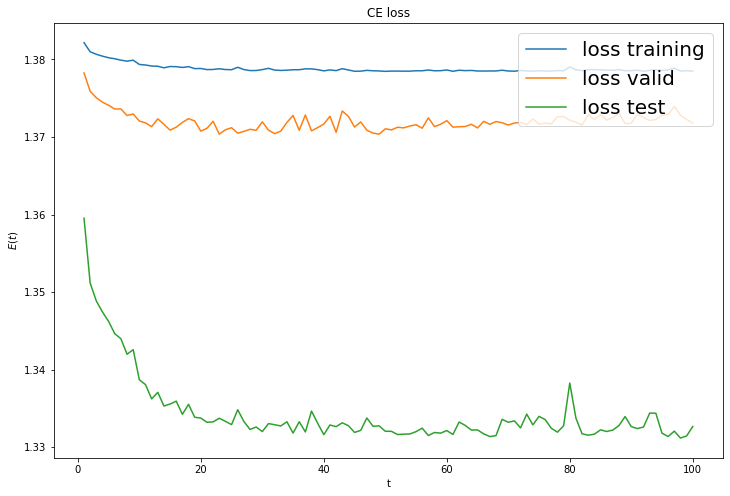

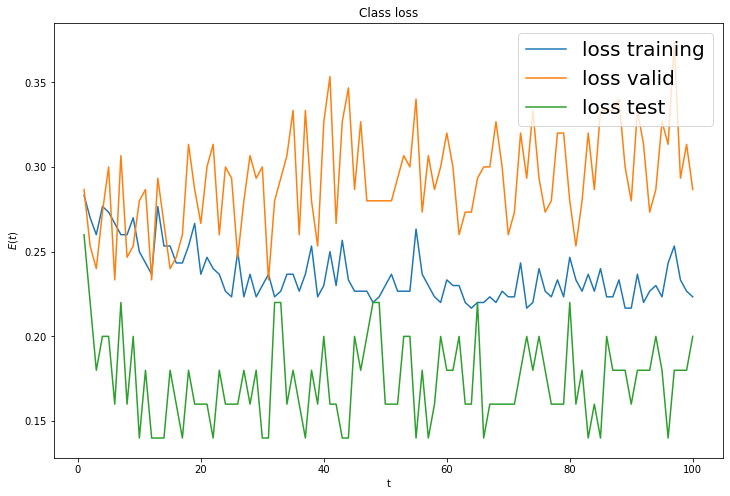

In [38]:
result = fit_net(net, x_train, y_train, x_valid, y_valid, x_test, y_test, epoch = 100, lr = 0.05, momentum = 0.1)

visualize_losses(result[0:3], 'CE loss')
visualize_losses(result[3:], 'Class loss')

In [39]:
print(get_df_losses(result))

            train  valid   test
CE_loss     1.379  1.372  1.333
Class loss  0.223  0.287  0.200


In [40]:
print(f"Matrix training losses:\n {get_losses_matrix(net, x_train, y_train)}")
print()
print(f"Matrix test losses:\n {get_losses_matrix(net, x_test, y_test)}")

Matrix training losses:
        Pred 1  Pred 2  Pred 3  Pred 4
Act 1      52       1       4       0
Act 2       0      82       7       0
Act 3      12       7      64       5
Act 4       0       4      27      35

Matrix test losses:
        Pred 1  Pred 2  Pred 3  Pred 4
Act 1       9       0       0       0
Act 2       0      11       4       0
Act 3       1       2      12       1
Act 4       0       0       2       8


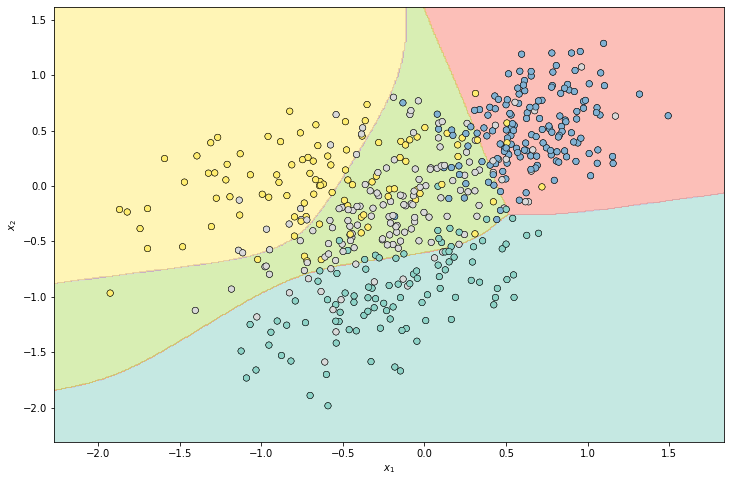

In [41]:
plot_decision_boundary(net, x_train, y_train, x_valid, y_valid, x_test, y_test)

<h2>Проверка устройчивости НС</h2>

            train  valid   test
CE_loss     1.379  1.372  1.333
Class loss  0.213  0.313  0.180


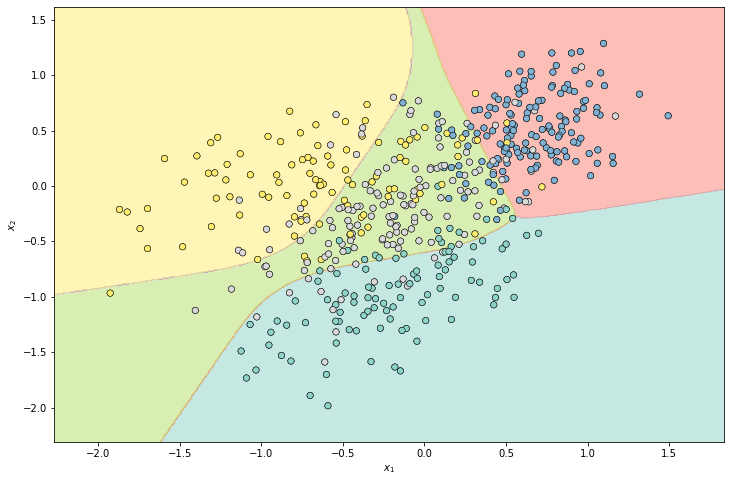

In [42]:
net2 = ClassNet()
result2 = fit_net(net2, x_train, y_train, x_valid, y_valid, x_test, y_test, epoch = 100, lr = 0.05, momentum = 0.1)

print(get_df_losses(result2))
plot_decision_boundary(net2, x_train, y_train, x_valid, y_valid, x_test, y_test)